# Perculation Simulation

## The drawing table

First of all we have to create a grid of size L. With a $p$ probability that each of the squares inside the raster is occupied.
We will do this by creating a matrix where all the elements are initially zero and have a chance $p$ to be 1.

In [255]:
import numpy as np
import random
import time
from scipy.optimize import curve_fit
import collections

In [10]:
#this function will give True or False to later determine what elements will be coloured in the grid.
def decision(probability):
    return random.random() < probability

In [11]:
def one_or_zero(el, probability):
    if decision(probability):
        return 1
    else:
        return 0

In [12]:
def create_world(size,probability):
    vector= np.zeros(size**2)  #create vector to make the iteration easier
    vector[:] = [one_or_zero(el,probability) for el in vector]   #make certain elements one and zero depending on the prob
    return vector.reshape(size,size)    #reshape the vector to a matrix

In [13]:
M=create_world(5,0.5)
M

array([[0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1.],
       [1., 1., 0., 0., 0.]])

In [14]:
from matplotlib import pyplot as plt
from matplotlib import colors

def draw_array(M):
    cmap = colors.ListedColormap(['White','Red'])
    plt.figure(figsize=(5,5))
    plt.pcolor(M[::-1],cmap=cmap,edgecolors='k', linewidths=0.1)
    plt.show()

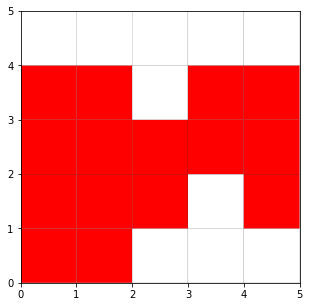

In [15]:
draw_array(M)

## How to count?

We will now implement an algoritm to count the amount of clusters in the grid. The method I have chosen is the Hoshen and Kopelman algortim.

The function below returns the number of clusters, the list in where the clusters are counted with their respective number of sites (negative means that this one is 'slorped' by another cluster), the matrix in which the different numbers can be shown,  the number of unoccupied sites and the number of the sites in the largest cluster.

In [16]:
def occupied(el):
    return el==1

In the method we have to keep up with the track of how the cluster size of a cluster. We do this by making a list. Which after several iterations look like this as an example:

In [17]:
np.array([3.,0.,3.,2.,1.])

array([3., 0., 3., 2., 1.])

Because of how indexing works in Python. In the above array we have that the amount of zeros is equal to 3. The amount of cluster 2 is 3, cluster 3 is 2 etc...

However, when two clusters meet, for example cluster 2 and 3 we merge the two clusters to the cluster of the upper one. The cluster size of 3 is transferred to cluster 2 and cluster two will be pointed to cluster 2.
And the list should look the following:

In [18]:
y=np.array([3.,0.,5.,-2.,1.])

And then when we get a new occupied space that is related to cluster 3, the new zone should be counted for for the 'true label' of cluster 3, which is cluster 2.
The following function helps us with that:

In [19]:
def get_true_label(value,lijst):
    true_value=value
    if lijst[int(value)]>0:
        true_value = true_value
    else:
        true_value=get_true_label(-lijst[int(value)], lijst)
        lijst[int(value)]=-true_value
    return true_value

In [20]:
get_true_label(3,y)

2.0

In [21]:
Y=np.array([3.,0.,5.,-2.,-3.])

When the upper cluster $\textit{already}$ is pointed to another cluster we still et the true label:

In [22]:
get_true_label(4,Y)

2.0

In [23]:
Y

array([ 3.,  0.,  5., -2., -2.])

The next function works the same way but instead it returns the value, it returns the cluster size of the 'true label'- cluster. This is needed when the cluster is being assigned, is already pointed to another cluster. 

In [24]:
def get_true_label_value(value,lijst):
    if lijst[int(value)]>0:
        return lijst[int(value)]
    else:
        return get_true_label_value(-lijst[int(value)], lijst)

In [25]:
x=np.array([3.,0.,5.,-2.,-2.])
get_true_label_value(4,x)

5.0

Next function counts one for the true cluster if nothing is being merged or anything.

In [26]:
def count_true_cluster(cell,lijst):
    label=get_true_label(cell,lijst)
    lijst[int(label)]+=1

Now we have everything for the algoritm.

In [27]:
def Hoshen_and_Kopelman(matrix):
    U=np.copy(matrix)
    size=len(matrix)
    l=2
    lijst =np.zeros(round((len(matrix)**2)/2))
    if occupied(U[0,0]):  #first element
        U[0,0]=l
        lijst[l]+=1
        l+=1
    else:
        lijst[0]+=1
        
    for j in range(len(U[0,:])-1): #top row
        j+=1
        if occupied(U[0,j]):
            if U[0,j-1]!=0:         #look left
                U[0,j]=U[0,j-1]
                lijst[int(U[0,j-1])]+=1.
            else:
                U[0,j]=l
                lijst[l]+=1
                l+=1
        else:
            lijst[0]+=1
    for i in range(len(U[0,:])-1):
        i+=1
        for j in range(len(U[:,0])):
            if j==0:                           #first column does not have to look left
                if occupied(U[i,0]):
                    if U[i-1,0]!=0:           #look up
                        U[i,0]=U[i-1,0]
                        count_true_cluster(U[i,0],lijst)
                    else:
                        U[i,0]=l
                        lijst[l]+=1
                        l+=1
                else:
                    lijst[0]+=1
            

            elif occupied(U[i,j]):                
                if U[(i-1),j]!=0:            #look up
                    U[i,j]=U[i-1,j]
                    count_true_cluster(U[i,j],lijst)
                        
                    if U[i,j-1]!=0:             #look left AND right to merge
                        if get_true_label(U[i,j],lijst)!=get_true_label(U[i,j-1],lijst):  #if both elements are from the same cluster, mer
                                
#                               #below is the tricky part, we have to add the true label size! of left to cluster of the current one (=cluster of top one)
                                lijst[int(get_true_label(U[i,j],lijst))]+=(get_true_label_value(U[i,j-1], lijst)) 
                                lijst[int(get_true_label(U[i,j-1],lijst))]=-U[i,j] #and now the true label of left becomes the current one
             
                elif U[i,j-1]!=0:         #look left
                    U[i,j]=U[i,j-1]
                    count_true_cluster(U[i,j],lijst)
                    
                else:
                    U[i,j]=l
                    lijst[l]+=1
                    l+=1
            else:
                lijst[0]+=1
          
    cluster_sizes_without_largest_one= [i  for i in lijst[1:] if i>0]
    cluster_sizes= np.copy(cluster_sizes_without_largest_one) 
    
    number_of_clusters= len(cluster_sizes)
    
    largest_cluster=max(lijst[1:])
    
    np.array(cluster_sizes_without_largest_one.remove(largest_cluster))
    
    average_cluster_sizes_without_largest_one= sum(cluster_sizes_without_largest_one) / (number_of_clusters)
    
    fraction = largest_cluster/(size**2)
    
    return [number_of_clusters, lijst, largest_cluster, fraction, cluster_sizes, cluster_sizes_without_largest_one, average_cluster_sizes_without_largest_one]

Hoshen_and_Kopelman(M)

[1,
 array([10.,  0., -3., 15.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 15.0,
 0.6,
 array([15.]),
 [],
 0.0]

## Example

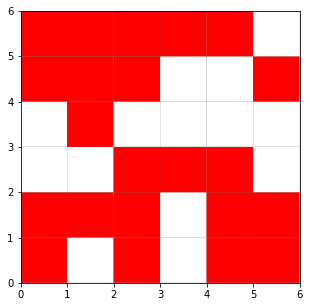

In [28]:
M=create_world(6,0.5)
small_world=Hoshen_and_Kopelman(M)
draw_array(M)

Number of clusters:

In [29]:
small_world[0]

3

Largest cluster size:

In [30]:
small_world[2]

12.0

## Time

In [49]:
M=create_world(500,0.2)
# draw_array(M)
toc= time.time()
HK=Hoshen_and_Kopelman(M)
tic = time.time()
t=tic-toc
t

0.37828779220581055

In [50]:
HK[4]

array([2., 1., 1., ..., 1., 1., 1.])

In [51]:
def smiley():
    S=np.zeros(6*8).reshape(6,8)
    S[1,2]=1
    S[1,5]=1
    S[-3,1]=1
    S[-2,2:6]=1
    S[-3,6]=1
    draw_array(S)

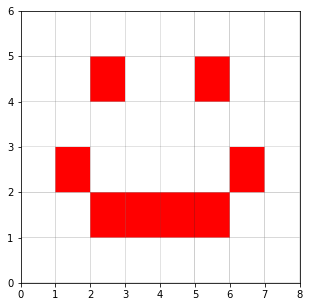

In [52]:
smiley()

# Order Parameters

In [109]:
def func(x, a, b):
    return a*(x)**b

In [54]:
var_p=np.linspace(0.1,0.5,10)
var_p=np.append(var_p,np.linspace(0.51,0.65,num=30))
var_p=np.append(var_p,np.linspace(0.66,0.99,num=10))
# var_p=np.linspace(0.01,0.99,15)

In [56]:
def perculation(x,size):
    occupation_fraction=[]
    average_cluster_size=[]
    for p in x:
        M=create_world(size,p)
        HK=Hoshen_and_Kopelman(M)
        occupation_fraction.append(HK[3])
        average_cluster_size.append(HK[6])
    return [occupation_fraction, average_cluster_size]

In [57]:
def average(x,size, iterations):
    count_occupation=np.zeros(len(x))
    average_cluster_size=np.zeros(len(x))
    for it in range(iterations):
        a=perculation(x,size)
        count_occupation+=a[0]
        average_cluster_size+=a[1]
        print(it)
    return [count_occupation/iterations, average_cluster_size/iterations]

In [58]:
toc= time.time()
occupation =average(var_p,250, 15)
tic = time.time()
tic-toc

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


230.69698929786682

## $P_c$

In [69]:
id=next(x[0] for x in enumerate(occupation[0]) if x[1] > 0.18)
Pc=var_p[id]
Pc

0.5872413793103448

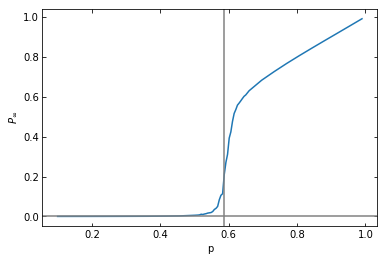

In [338]:
f = plt.figure()
ax = f.add_subplot(111)
ax.tick_params(axis="both", direction="in", top=True, right=True)

plt.plot(var_p,Pinf)
plt.axhline(y=0,color='grey')
plt.axvline(x=var_p[id],color='grey')
plt.xlabel('p')
plt.ylabel('$P_{\infty}$')
plt.show()

# $P_{\infty}$

In [75]:
Pinf=occupation[0]

In [123]:
var_beta=var_p[(id+1):]
Pinf_beta=Pinf[(id+1):]

In [125]:
popt, pcov = curve_fit(func, (var_beta- P_c),Pinf_beta)
popt

array([1.22625682, 0.25945453])

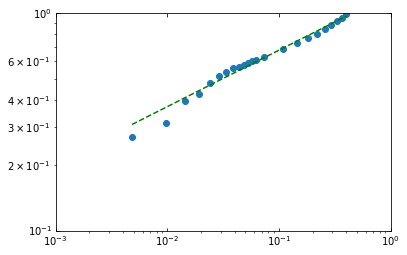

beta = 0.25945453073137115


In [156]:
f = plt.figure()
ax = f.add_subplot(111)
ax.tick_params(axis="both", direction="in", top=True, right=True)

plt.scatter(var_beta- Pc,Pinf_beta)
plt.plot((var_beta- Pc), func(var_beta- Pc, *popt), '--', color='green')

plt.xscale('log')
plt.yscale('log')

plt.xlim(10**(-3), 1)
plt.ylim(0.1, 1)

plt.show()
print('beta =', popt[1])

## Average Cluster Size

In [160]:
acs=occupation[1]

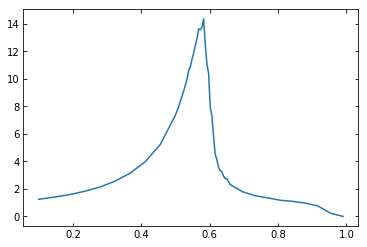

In [161]:
f = plt.figure()
ax = f.add_subplot(111)
ax.tick_params(axis="both", direction="in", top=True, right=True)

plt.plot(var_p,acs)
plt.show()

In [340]:
#positive
var_gamma=var_beta
acs_gamma=acs[(id+1):]

#negative
var_gamma2=var_p[:(id-1)]
acs_gamma2=acs[:(id-1)]

If we look at the graph below, we have to specify a cut-off value from were we want our function to be fitted.

In [341]:
cutoff=0.1
xdata=[el for el in abs(var_gamma2-Pc) if el>cutoff]
ydata=acs_gamma2[:len(xdata)]

In [342]:
popt, pcov = curve_fit(func, (xdata),ydata)
gamma=-popt[1]
popt

array([ 0.6042143 , -1.07166544])

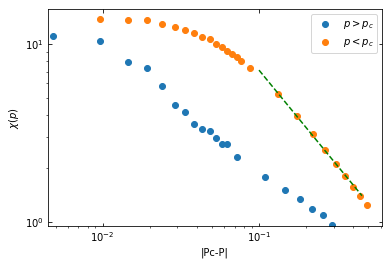

$\gamma$= 1.0716654420960616


In [343]:
f = plt.figure()
ax = f.add_subplot(111)
ax.tick_params(axis="both", direction="in", top=True, right=True)

plt.scatter(var_gamma- Pc,acs_gamma, label='$p>p_c$')
plt.scatter((Pc-var_gamma2),acs_gamma2, label='$p<p_c$')
plt.plot((Pc-xdata), func(Pc-xdata, *popt), '--', color='green')

plt.xscale('log')
# plt.xlim(10**(-5), 1)

plt.yscale('log')
# plt.ylim(0.1, 1)
plt.xlabel('|Pc-P|')
plt.ylabel('$\chi(p)$')
plt.legend()
plt.show()
print('$\gamma$=', gamma)

## Cluster Number Density

The following defined function will use the result of Hoshen and Kopelman of the clusters. With the list of the clusters it will calculate the frequency of the clusters by using a dictionairy. And it wil average out in the end.
I see it in a way to reduce 'noise'.

In [269]:
def cluster_number_density(size, p, iterations):
    appearances=collections.defaultdict(int)
    
    for i in range(iterations):
        M=create_world(size,p)
        HK=Hoshen_and_Kopelman(M)
        for curr in HK[4]:
            appearances[curr] += 1
        print('Still working')
            
    data = list(appearances.items())
    
    an_array = np.array(data)
    an_array[:,1]=an_array[:,1]/(size)**2

    an_array=an_array[np.argsort(an_array[:,0])]
    an_array[:,1]=an_array[:,1]/iterations
    
    return an_array

Example with noise

In [270]:
cnd=cluster_number_density(500,0.5,1)

Still working


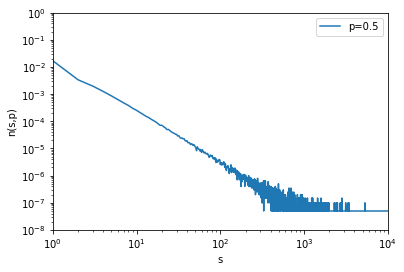

In [334]:
plt.plot(cnd[:,0],cnd[:,1],label='p=0.5')
# plt.plot(10,1/(200**2),'o')
plt.yscale('log')
plt.ylim(10**-8, 1)
plt.xlim(1, 10**4)
plt.xscale('log')
plt.xlabel('s')
plt.ylabel('n(s,p)')
plt.legend()
plt.show()

Example with less noise

In [275]:
cnd=cluster_number_density(1000,0.59,20)
s=cnd[:,0]
n=cnd[:,1]

Still working
Still working
Still working
Still working
Still working
Still working
Still working
Still working
Still working
Still working
Still working
Still working
Still working
Still working
Still working
Still working
Still working
Still working
Still working
Still working


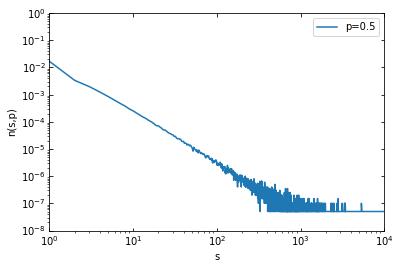

In [335]:
f = plt.figure()
ax = f.add_subplot(111)
ax.tick_params(axis="both", direction="in", top=True, right=True)

plt.plot(s,n,label='p=0.5')
# plt.plot(10,1/(200**2),'o')
plt.yscale('log')

plt.ylim(10**-8, 1)
plt.xlim(1, 10**4)

plt.xscale('log')

plt.xlabel('s')
plt.ylabel('n(s,p)')

plt.legend()
plt.show()

In [331]:
cut_off=70
xdata_tau=[el for el in s if el<cut_off]
ydata_tau=n[:len(xdata)]

In [332]:
popt, pcov = curve_fit(func, xdata_tau, ydata_tau)
tau=-popt[1]
popt

array([ 0.01669803, -2.07459025])

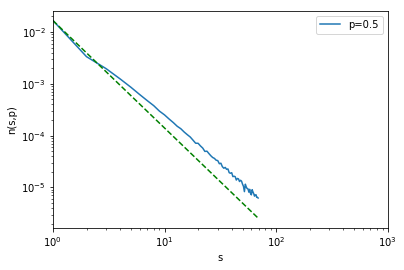

tau = 2.0745902450968052


In [336]:
plt.loglog(xdata_tau,ydata_tau,label='p=0.5')
plt.loglog(xdata_tau, func(xdata_tau, *popt), 'g--')
plt.xlim(1,1000)
plt.xlabel('s')
plt.ylabel('n(s,p)')
plt.legend()
plt.show()
print('tau =', tau)